<a href="https://colab.research.google.com/github/rubuntu/Taller_Introduccion_a_Ciencia_de_Datos_IA_e_Ingenieria_de_Datos/blob/main/sesion_14_introduccion_a_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧑‍💻 Sesión 14 – Introducción a Transformers y BERT

## Objetivos:

- Entender la arquitectura Transformer (atención, capas, encoder-decoder).
- Explorar BERT y RoBERTa como modelos de lenguaje preentrenados.
- Realizar inferencia con BERT preentrenado.

## Hands-on checklist:

1. Explicar con visualización cómo funciona la atención (usar un ejemplo toy).
2. Cargar modelo BERT base desde HuggingFace (bert-base-uncased).
3. Tokenizar texto con AutoTokenizer.
4. Generar embeddings de frases y palabras.
5. Visualizar embeddings con PCA/TSNE para comparar semántica.
6. Usar embeddings de BERT como features para un clasificador sencillo.

In [1]:
# ==========================================
# SESIÓN 14: Transformers y BERT
# ==========================================

#!pip install transformers datasets torch -q

from transformers import AutoTokenizer, AutoModel
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

---

## 1. Cargar modelo y tokenizer

In [2]:
# Usaremos BERT base uncased (versión pequeña)
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

---

## 2. Tokenización de ejemplos

In [3]:
# Ejemplo de frases
sentences = [
    "I love banking and data science.",
    "The customer service was terrible.",
    "Artificial Intelligence will transform finance.",
    "I hate hidden fees in my bank account."
]

# Tokenizamos
inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

print("Tokens:", inputs["input_ids"].shape)
print("Ejemplo de tokens:", inputs["input_ids"][0][:10])
print("Tokens decodificados:", tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][:10]))

Tokens: torch.Size([4, 11])
Ejemplo de tokens: tensor([ 101, 1045, 2293, 8169, 1998, 2951, 2671, 1012,  102,    0])
Tokens decodificados: ['[CLS]', 'i', 'love', 'banking', 'and', 'data', 'science', '.', '[SEP]', '[PAD]']


---

## 3. Generar embeddings con BERT

In [4]:
# Pasamos por el modelo
with torch.no_grad():
    outputs = model(**inputs)

# outputs.last_hidden_state: [batch, seq_len, hidden_dim]
# outputs.pooler_output: [batch, hidden_dim] → embedding de la frase
sentence_embeddings = outputs.pooler_output

print("Shape de embeddings:", sentence_embeddings.shape)

Shape de embeddings: torch.Size([4, 768])


---

## 4. Visualizar embeddings en 2D

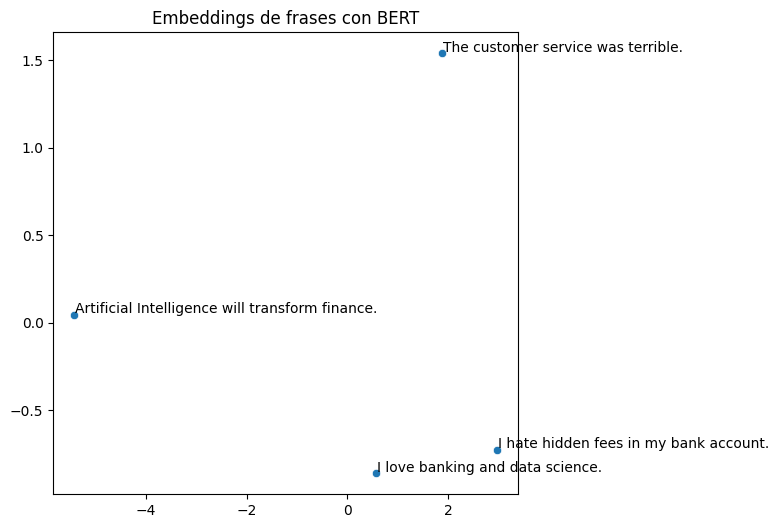

In [5]:
# Reducimos dimensionalidad con PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(sentence_embeddings.numpy())

# Graficamos
plt.figure(figsize=(6,6))
sns.scatterplot(x=reduced[:,0], y=reduced[:,1])

for i, txt in enumerate(sentences):
    plt.annotate(txt, (reduced[i,0]+0.01, reduced[i,1]+0.01))

plt.title("Embeddings de frases con BERT")
plt.show()

---

## 5. Comparar embeddings palabra a palabra

In [6]:
# Ejemplo con una sola frase
example = "The bank charges hidden fees."
tokens = tokenizer(example, return_tensors="pt")

with torch.no_grad():
    outputs = model(**tokens)

word_embeddings = outputs.last_hidden_state.squeeze(0)

print("Shape:", word_embeddings.shape)  # (seq_len, hidden_dim)

# Mostrar los tokens y primeras 5 dimensiones del embedding
for token_id, emb in zip(tokens["input_ids"][0], word_embeddings):
    token = tokenizer.decode([token_id.item()])
    print(f"{token:15s} -> {emb[:5].numpy()}")

Shape: torch.Size([8, 768])
[CLS]           -> [-0.10813279  0.27535188 -0.28518695  0.08077639  0.08981509]
the             -> [ 0.05496771 -0.43629134 -0.64114547  0.46576315  0.21727327]
bank            -> [ 0.49818915 -0.3275908  -0.35184348  0.3922326   1.1563535 ]
charges         -> [ 0.20339668 -0.16953011  0.13515201  0.46464208  0.4563305 ]
hidden          -> [ 0.61171234 -0.50296146  0.48632395  0.05874917  1.0755503 ]
fees            -> [ 1.1862234  -0.4281657   0.080603    0.34931877  0.8495467 ]
.               -> [ 0.18181212 -0.43470737 -0.31730032  0.38275018  0.15656032]
[SEP]           -> [ 0.65420955  0.42311448 -0.25857335  0.7487688  -0.06639767]


---

## 6. Preguntas de discusión:
- ¿Notas cómo **tokens similares** (ej: "bank", "finance") aparecen cerca en el espacio de embeddings?
- ¿Cómo cambia esto respecto a un **Bag-of-Words**, donde “bank” = vector one-hot sin semántica?
- ¿Qué ventajas aporta la autoatención frente a secuencias RNN/LSTM?
- ¿Por qué es mejor usar embeddings contextuales?

